# Correlations

In [1]:
library(tidyverse)
library(tidyr)
library(dplyr)
library(ggplot2)
library(readxl)
library(openxlsx)
library(lattice)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## importing data

In [61]:
# Read a CSV file into a data frame
df <- read.csv("Data/All_dat_df.csv")
df$NO <- df$NOX - df$NO2

In [63]:
head(df)

,site,datetime,year,month,day,hour,dayofwk,daytype,season,O3,⋯,TEMP,PREC,RAD,SO2,PM2.5,EC,CPC,avg_wind_speed,avg_wind_direction,NO
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,57.7,⋯,-2.2,0,-0.6,NA,NA,NA,NA,1.0980000,36.25794,0.0
2,DAV,2024-01-01 01:00:00,2024,1,1,1,Mon,Weekday,Winter,55.2,⋯,-2.8,0,-0.7,NA,NA,NA,NA,0.9216667,40.71351,0.0
3,DAV,2024-01-01 02:00:00,2024,1,1,2,Mon,Weekday,Winter,49.9,⋯,-3.3,0,-0.7,NA,NA,NA,NA,0.6716667,150.12313,0.0
4,DAV,2024-01-01 03:00:00,2024,1,1,3,Mon,Weekday,Winter,52.1,⋯,-4.2,0,-1.1,NA,NA,NA,NA,0.5250000,40.87731,0.1
5,DAV,2024-01-01 04:00:00,2024,1,1,4,Mon,Weekday,Winter,65.8,⋯,-5.2,0,-1.3,NA,NA,NA,NA,1.4700000,186.90946,0.0
6,DAV,2024-01-01 05:00:00,2024,1,1,5,Mon,Weekday,Winter,67.1,⋯,-5.6,0,-0.8,NA,NA,NA,NA,1.9350000,184.88936,0.0


In [77]:
# Access column names
colnames(df)
variables <- c('O3','NO2','PM10','NOX','TEMP','PREC','RAD','SO2','PM2.5','EC','CPC','avg_wind_speed','avg_wind_direction', 'NO')

[1] "site"               "datetime"           "year"              
 [4] "month"              "day"                "hour"              
 [7] "dayofwk"            "daytype"            "season"            
[10] "O3"                 "NO2"                "PM10"              
[13] "NOX"                "TEMP"               "PREC"              
[16] "RAD"                "SO2"                "PM2.5"             
[19] "EC"                 "CPC"                "avg_wind_speed"    
[22] "avg_wind_direction" "NO"

In [78]:
lf <- pivot_longer(df, all_of(variables), names_to = "variable", values_to = "value")
daily.max <- lf %>%
  group_by(site, year, month, day, season, variable) %>%
  summarize(value = max(value, na.rm=TRUE), .groups = "drop") %>%
  pivot_wider(names_from = variable, values_from = value)

Warning message:
"There were 1487 warnings in `summarize()`.
The first warning was:
ℹ In argument: `value = max(value, na.rm = TRUE)`.
ℹ In group 183: `site = "BAS"`, `year = 2024`, `month = 1`, `day = 14`, `season = "Winter"`, `variable = "CPC"`.
Caused by warning in `max()`:
! aucun argument pour max ; -Inf est renvoyé
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1486 remaining warnings."


In [79]:
head(daily.max)

site,year,month,day,season,CPC,EC,NO,NO2,NOX,O3,PM10,PM2.5,PREC,RAD,SO2,TEMP,avg_wind_direction,avg_wind_speed
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BAS,2024,1,1,Winter,16766.3,0.8,2.1,32.6,34.7,71.7,35.8,25.2,1.4,191.0,2.2,8.3,267.4726,4.333333
BAS,2024,1,2,Winter,10805.3,0.4,1.3,22.1,23.3,85.3,10.3,6.7,2.0,79.2,4.5,12.4,242.9949,8.133333
BAS,2024,1,3,Winter,2405.6,0.1,1.0,2.1,2.9,84.1,4.1,2.0,2.6,276.7,0.2,13.7,257.8373,9.083333
BAS,2024,1,4,Winter,14598.9,0.8,1.0,32.8,33.2,83.1,12.9,7.8,0.3,245.8,1.2,10.2,265.1611,7.000000
BAS,2024,1,5,Winter,17940.7,1.7,55.7,45.1,99.2,33.1,24.7,15.7,0.5,66.7,2.9,6.3,237.9995,3.200000
BAS,2024,1,6,Winter,8110.8,0.7,0.7,14.2,14.3,54.1,13.8,11.3,0.5,114.8,0.6,6.2,294.1839,1.983333


### Dataset investigation

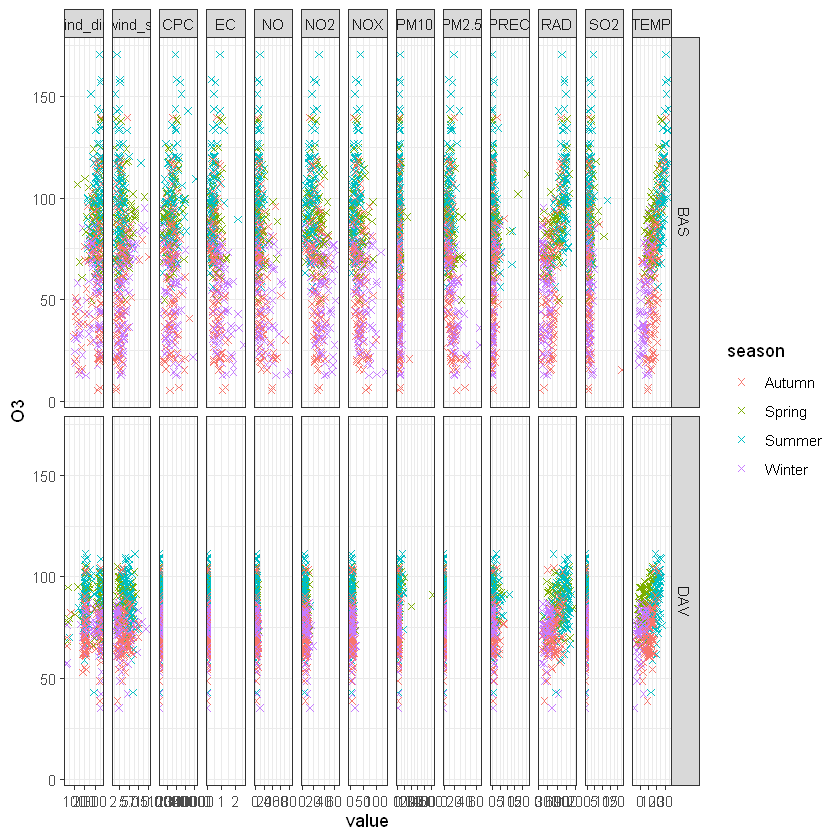

In [80]:
pivot_longer(daily.max, cols = all_of(setdiff(variables, "O3")), names_to = "variable", values_to = "value") %>% # everything but ozone
  ggplot+
  facet_grid(site~variable, scale="free_x")+
  geom_point(aes(value, O3, group=season, color=season), shape=4)

## Pairwise correlations plots for max daily values

In [81]:
Sys.setlocale("LC_TIME","C")
options(stringsAsFactors=FALSE)
theme_set(theme_bw()) # just my preference for plots

[1] "C"

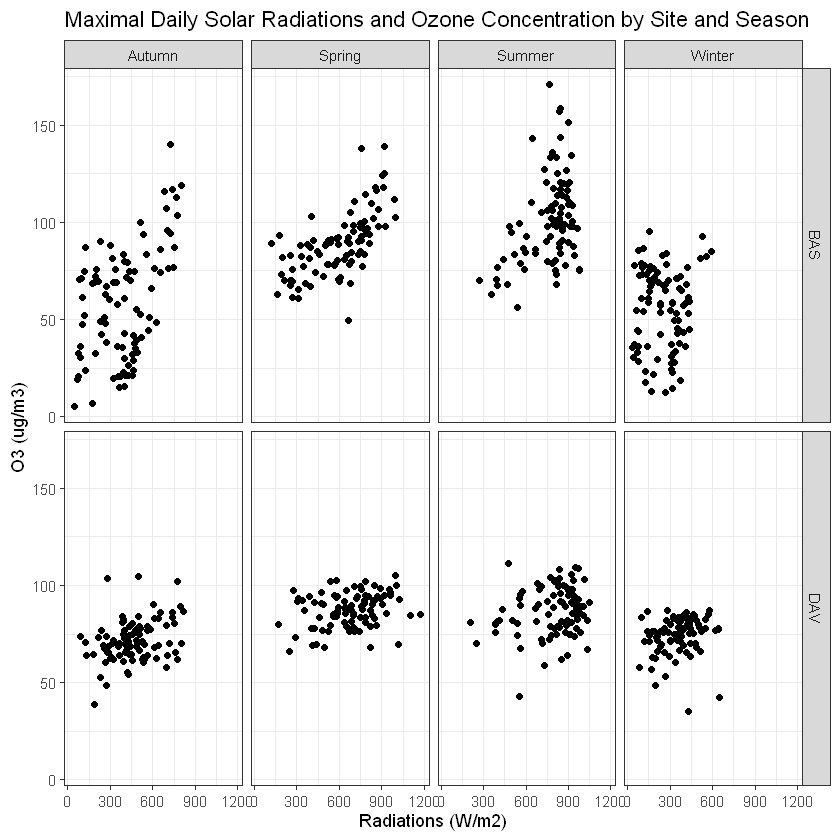

In [82]:
daily.max %>%
  ggplot+
  facet_grid(site~season)+
  geom_point(aes(RAD, O3))+
    labs(
    title = "Maximal Daily Solar Radiations and Ozone Concentration by Site and Season",
    x = "Radiations (W/m2)",
    y = "O3 (ug/m3)")

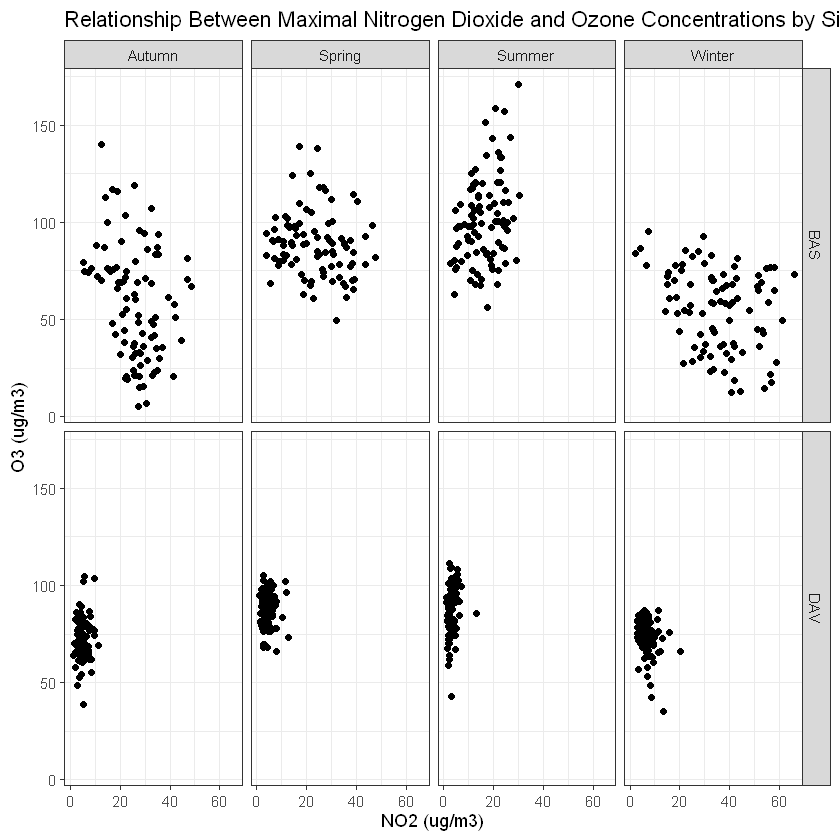

In [83]:
daily.max %>%
  ggplot+
  facet_grid(site~season)+
geom_point(aes(NO2, O3))+
labs(
    title = "Relationship Between Maximal Nitrogen Dioxide and Ozone Concentrations by Site and Season",
    x = "NO2 (ug/m3)",
    y = "O3 (ug/m3)")

### Pairwise correlation coefficients for max daily values

In [84]:
(cor.values.O3.NO2 <- daily.max %>% group_by(site, season) %>%
   summarize(correlation=cor(NO2, O3, use="pairwise.complete.obs"), .groups = "drop"))

site,season,correlation
<chr>,<chr>,<dbl>
BAS,Autumn,-0.30781192
BAS,Spring,-0.14485469
BAS,Summer,0.31947457
BAS,Winter,-0.29344664
DAV,Autumn,0.08346083
DAV,Spring,0.04540446
DAV,Summer,0.26180475
DAV,Winter,-0.33688443


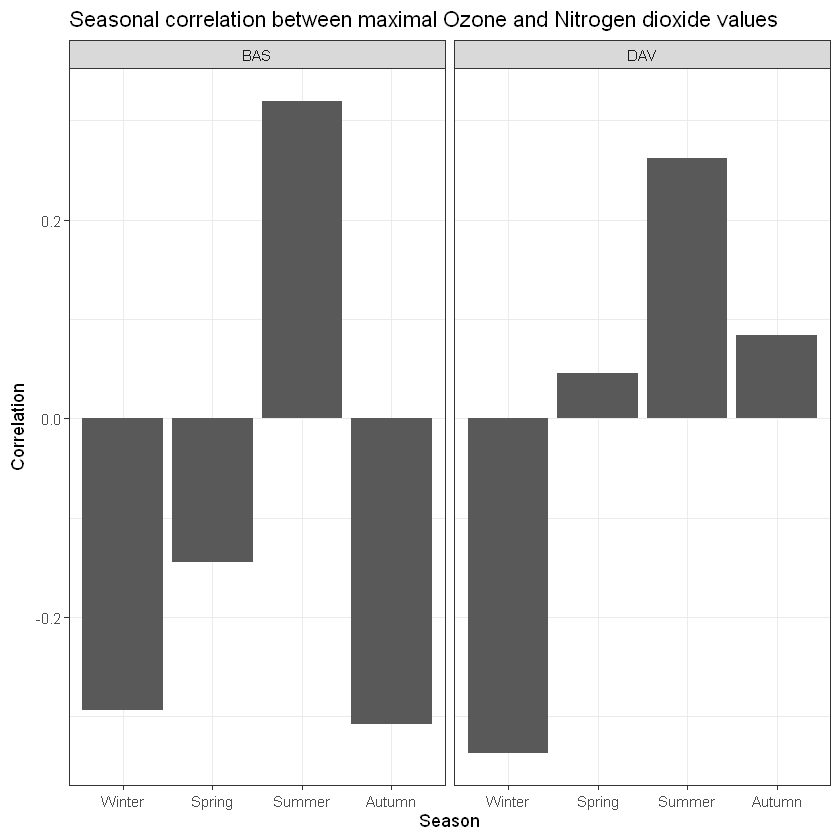

In [85]:
cor.values.O3.NO2$season <- factor(
  cor.values.O3.NO2$season,
  levels = c("Winter", "Spring", "Summer", "Autumn")
)

# Visualizing the correlation values
peak_corr_NO2_O3<- ggplot(cor.values.O3.NO2)+
  geom_col(aes(season, correlation))+
  #scale_y_continuous(limits=c(0,1), expand=expansion(mult=c(0, 0.1)))+
  facet_grid(.~site)+
    labs(
        x="Season", 
        y="Correlation",
        title="Seasonal correlation between maximal Ozone and Nitrogen dioxide values"
    )

peak_corr_NO2_O3
ggsave("outputs/peak_corr_NO2_O3.jpeg", plot = peak_corr_NO2_O3, width = 6, height = 5, dpi = 300)

In [86]:
(cor.values.O3.RAD <- daily.max %>% group_by(site, season) %>%
   summarize(correlation=cor(RAD, O3, use="pairwise.complete.obs"), .groups = "drop"))

site,season,correlation
<chr>,<chr>,<dbl>
BAS,Autumn,0.48354037
BAS,Spring,0.64592159
BAS,Summer,0.40186378
BAS,Winter,0.06396458
DAV,Autumn,0.32536434
DAV,Spring,0.25759305
DAV,Summer,0.21184778
DAV,Winter,0.17405099


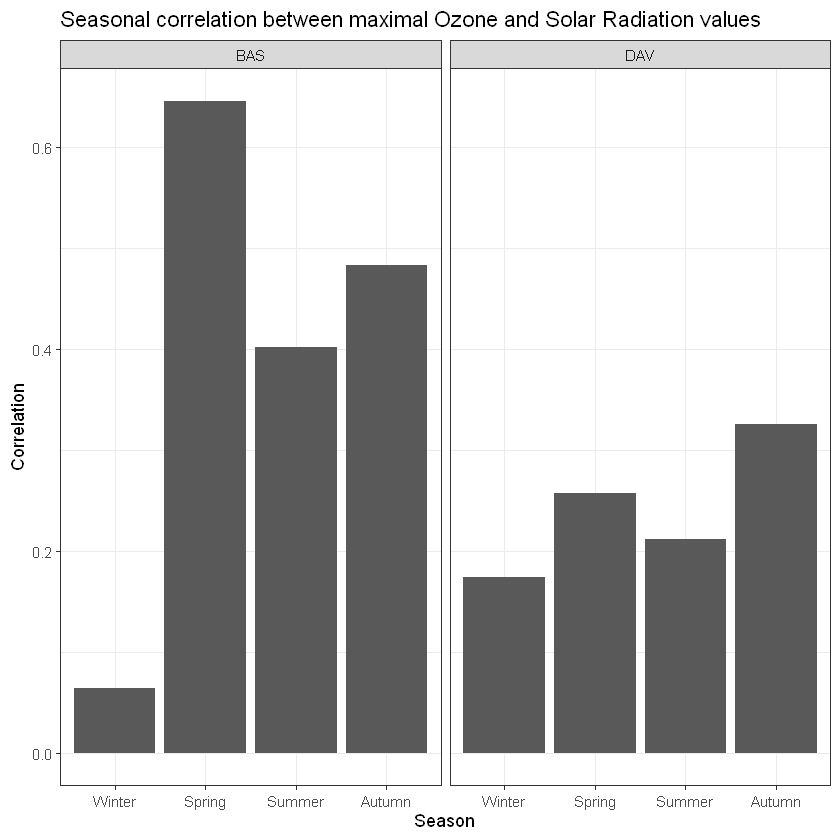

In [87]:
cor.values.O3.RAD$season <- factor(
  cor.values.O3.RAD$season,
  levels = c("Winter", "Spring", "Summer", "Autumn")
)

# Visualizing the correlation values
peak_corr_RAD_O3<- ggplot(cor.values.O3.RAD)+
  geom_col(aes(season, correlation))+
  #scale_y_continuous(limits=c(0,1), expand=expansion(mult=c(0, 0.1)))+
  facet_grid(.~site)+
    labs(
        x="Season", 
        y="Correlation",
        title="Seasonal correlation between maximal Ozone and Solar Radiation values"
    )

peak_corr_RAD_O3
ggsave("outputs/peak_corr_RAD_O3.jpeg", plot = peak_corr_RAD_O3, width = 6, height = 5, dpi = 300)

In [92]:
(cor.values.NOX <- daily.max %>% group_by(site, season) %>%
   summarize(correlation=cor(NO, NO2, use="pairwise.complete.obs"), .groups = "drop"))

site,season,correlation
<chr>,<chr>,<dbl>
BAS,Autumn,0.5146611
BAS,Spring,0.6649508
BAS,Summer,0.7490807
BAS,Winter,0.6317342
DAV,Autumn,0.5795942
DAV,Spring,0.7185206
DAV,Summer,0.7401935
DAV,Winter,0.7037366


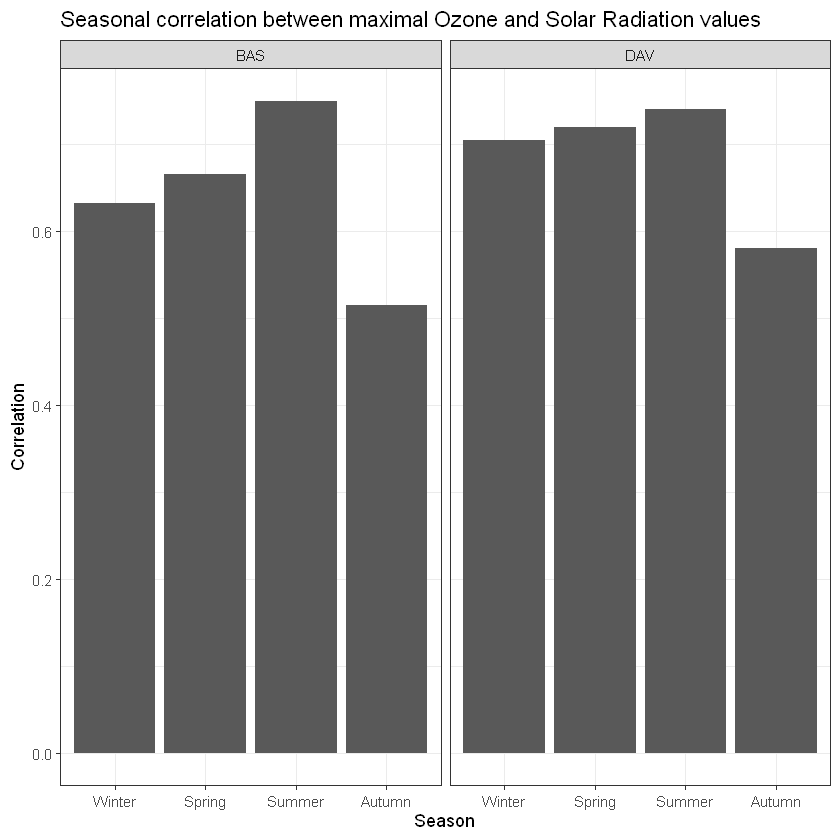

In [96]:
cor.values.NOX$season <- factor(
  cor.values.NOX$season,
  levels = c("Winter", "Spring", "Summer", "Autumn")
)

# Visualizing the correlation values
peak_corr_NOX<- ggplot(cor.values.NOX)+
  geom_col(aes(season, correlation))+
  #scale_y_continuous(limits=c(0,1), expand=expansion(mult=c(0, 0.1)))+
  facet_grid(.~site)+
    labs(
        x="Season", 
        y="Correlation",
        title="Seasonal correlation between maximal Ozone and Solar Radiation values"
    )

peak_corr_NOX
ggsave("outputs/peak_corr_NOX.jpeg", plot = peak_corr_NOX, width = 6, height = 5, dpi = 300)

### Correlation matrix 

In [76]:
CorrelationValue <- function(x, y, ...) {
  correlation <- cor(x, y, use="pairwise.complete.obs") 
  if(is.finite(correlation)) {
    cpl <- current.panel.limits()
    panel.text(mean(cpl$xlim), mean(cpl$ylim),
               bquote(italic(r)==.(sprintf("%.2f", correlation))),
               adj=c(0.5,0.5), col="blue")
  }
}

#### Daily max correlation matrix

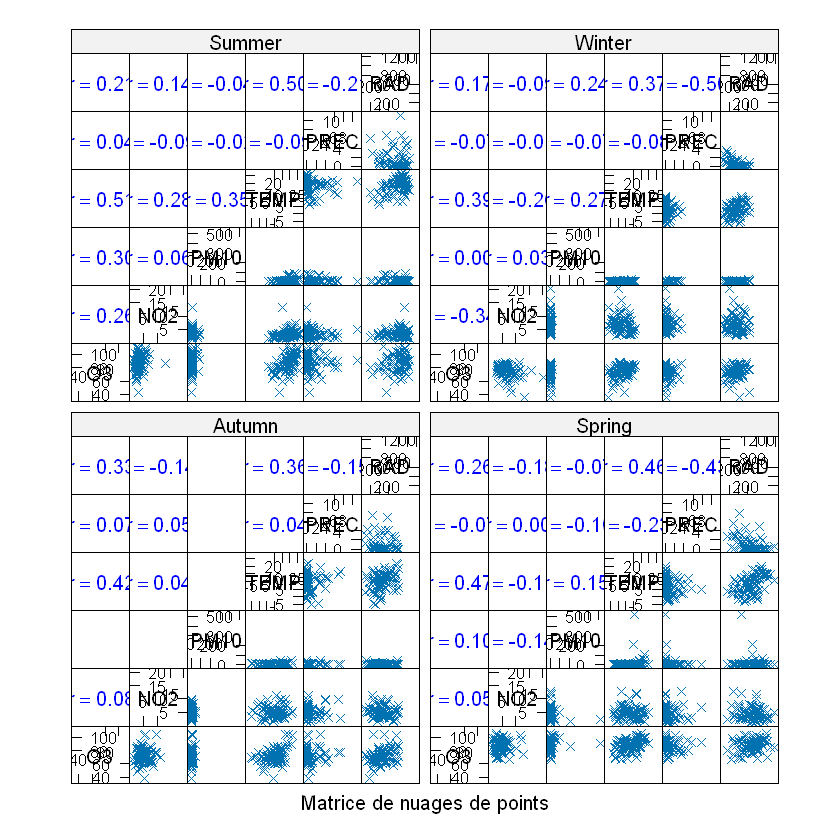

In [47]:
daily.max %>%
  filter("DAV" == site) %>%
  with(splom(~cbind(O3, NO2, PM10, TEMP, PREC, RAD) | season,
      upper.panel = CorrelationValue,
      pch=4))

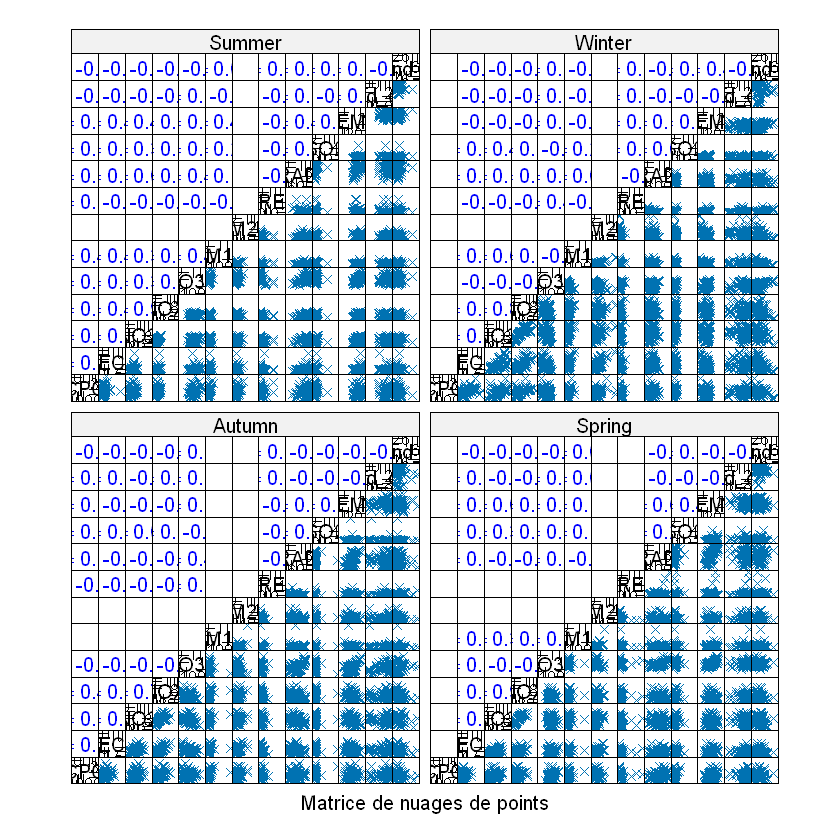

In [48]:
daily.max %>%
  filter("BAS" == site) %>%
  with(splom(~cbind(CPC, EC, NO2, NOX, O3, PM10, PM2.5, PREC, RAD, SO2,	TEMP, avg_wind_direction, avg_wind_speed) | season,
      upper.panel = CorrelationValue,
      pch=4))

#### Hourly data 

In [ ]:
df %>%
filter(grepl("BAS", site, fixed=TRUE)) %>%
with(splom(~cbind(O3, NO2, PM10, TEMP, PREC,RAD) | season,
      upper.panel = CorrelationValue,
      panel = panel.smoothScatter,
      pch=4, cex=.2, col="gray"))

In [ ]:
ggplot(df)+
  facet_grid(site~season)+
  geom_point(aes(O3, NO2))

### Lagged correlation

In [ ]:
Lag <- function(pair, k) {
  tibble(lag=k, head(pair[,1],-k), tail(pair[,2],-k))
}


lagged_NO2_O3 <- df %>%
  group_by(site, season) %>%
  do(bind_rows(
    Lag(select(., NO2, O3), 1),
    Lag(select(., NO2, O3), 2),
    Lag(select(., NO2, O3), 3),
    Lag(select(., NO2, O3), 4),
    Lag(select(., NO2, O3), 5),
    Lag(select(., NO2, O3), 6)
  ))

In [ ]:
NO2_O3_lagged_corr_plot <- ggplot(lagged_NO2_O3) +
  geom_point(aes(NO2, O3, group=site, color=site), shape=4)+
  facet_grid(lag~season)

NO2_O3_lagged_corr_plot
ggsave("outputs/NO2_O3_lagged_corr_plot.jpeg", plot = NO2_O3_lagged_corr_plot, width = 6, height = 5, dpi = 300)

In [ ]:
Lag <- function(pair, k) {
  tibble(lag=k, head(pair[,1],-k), tail(pair[,2],-k))
}


lagged_RAD_O3 <- df %>%
  group_by(site, season) %>%
  do(bind_rows(
    Lag(select(., RAD, O3), 1),
    Lag(select(., RAD, O3), 2),
    Lag(select(., RAD, O3), 3),
    Lag(select(., RAD, O3), 4),
    Lag(select(., RAD, O3), 5),
    Lag(select(., RAD, O3), 6)
  ))

In [ ]:
RAD_O3_lagged_corr_plot <- ggplot(lagged_RAD_O3) +
  geom_point(aes(RAD, O3, group=site, color=site), shape=4)+
  facet_grid(lag~season)

RAD_O3_lagged_corr_plot
ggsave("outputs/RAD_O3_lagged_corr_plot.jpeg", plot = RAD_O3_lagged_corr_plot, width = 6, height = 5, dpi = 300)

### hourly correlation plots and coefficients

## Cross correlations 

#### tests

pdf 
  2

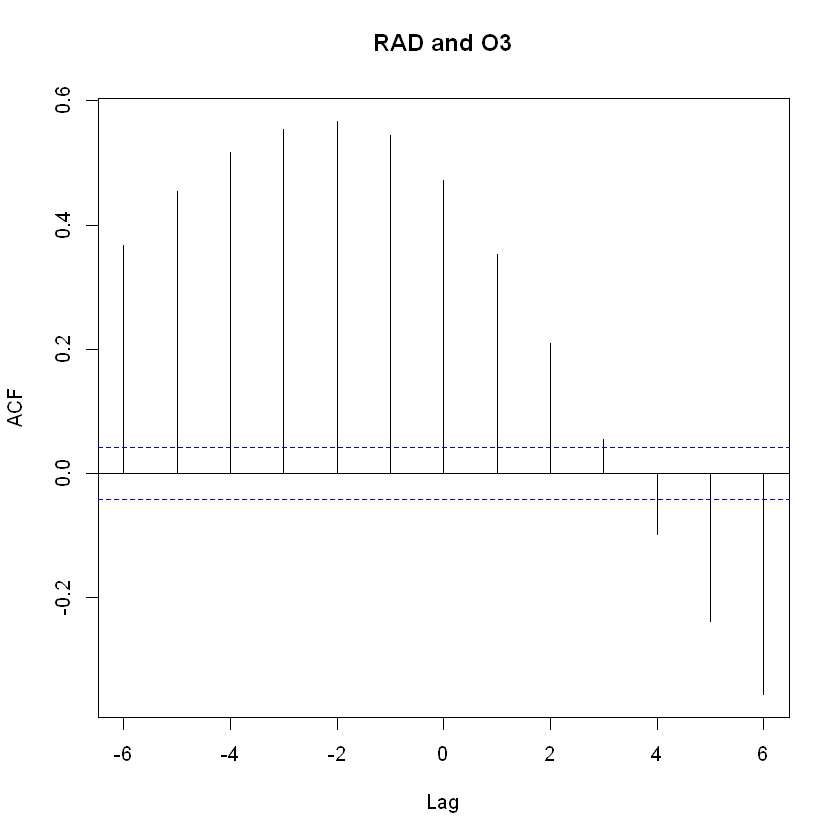

In [13]:
df_filtered <- df %>%
  filter(site == "DAV", season == "Summer")

# Cross-correlation function plot (returns a base R plot, not ggplot)
ccf_plot <- ccf(df_filtered$RAD, df_filtered$O3, lag.max = 6, na.action = na.pass,  main = "RAD and O3")

# Save the plot with a custom title
jpeg("outputs/lagged_visualization_RAD_O3.jpeg", width = 6, height = 5, units = "in", res = 300)
ccf(df_filtered$RAD, df_filtered$O3, lag.max = 6, na.action = na.pass, main = "RAD and O3")
dev.off()


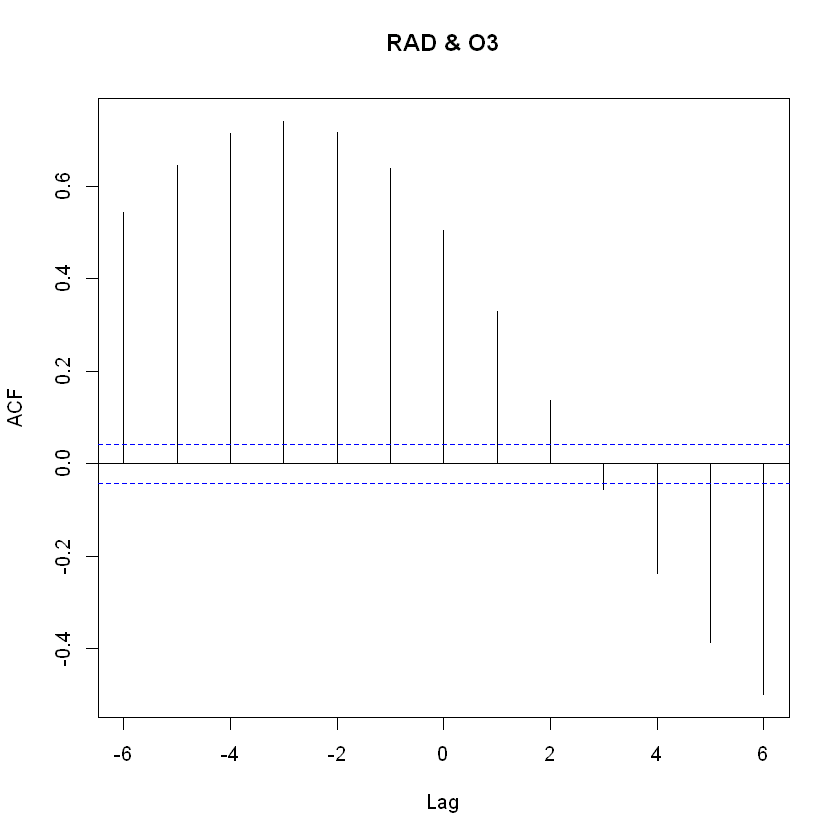

In [14]:
df %>%
  filter("BAS"==site & "Summer"==season) %>%
  with(ccf(RAD, O3, lag.max=6, na.action=na.pass))

#### results

In [15]:
LaggedCorrelation <- function(pair, ...) {
  out <- ccf(pair[,1], pair[,2], ..., na.action=na.pass, plot=FALSE)
  tibble(lag=out[["lag"]], value=out[["acf"]])
}

In [16]:
lagged_RAD_O3.values <- df %>% 
  group_by(site, season) %>%
  do(LaggedCorrelation(select(., RAD, O3), lag.max=6))

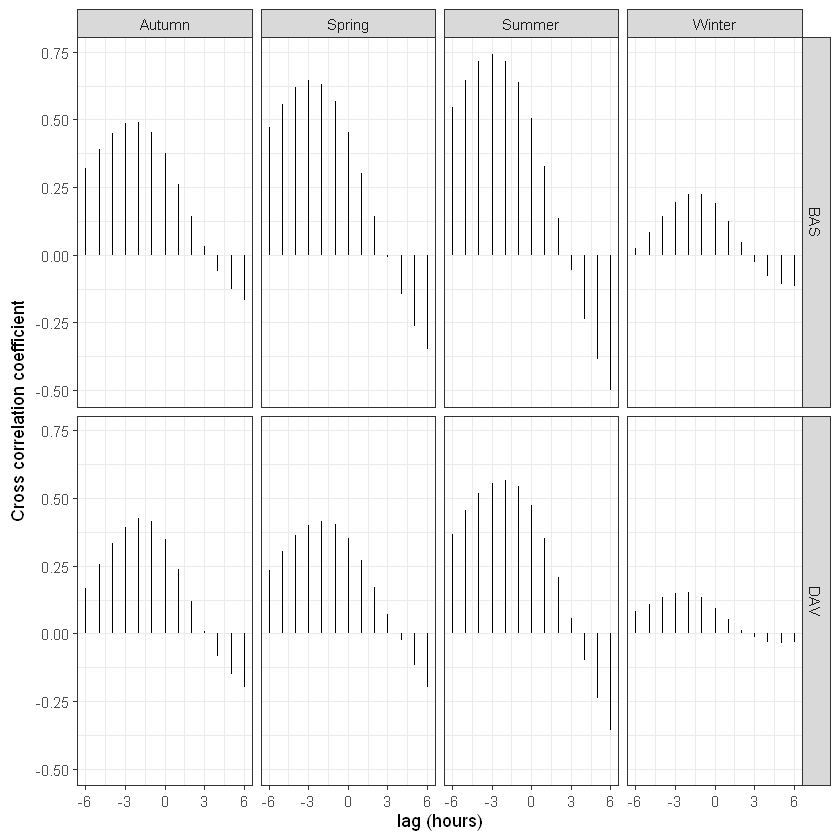

In [17]:
cross_corr_RAD_O3 <- ggplot(lagged_RAD_O3.values)+
  geom_segment(aes(x=lag,xend=lag,y=0,yend=value))+
  facet_grid(site~season)+
  xlab("lag (hours)")+
  ylab("Cross correlation coefficient")

cross_corr_RAD_O3
ggsave("outputs/cross_corr_RAD_O3.jpeg", plot = cross_corr_RAD_O3, width = 6, height = 5, dpi = 300)

In [30]:
lagged_NO2_O3.values <- df %>% 
  group_by(site, season) %>%
  do(LaggedCorrelation(select(., NO2, O3), lag.max=6))

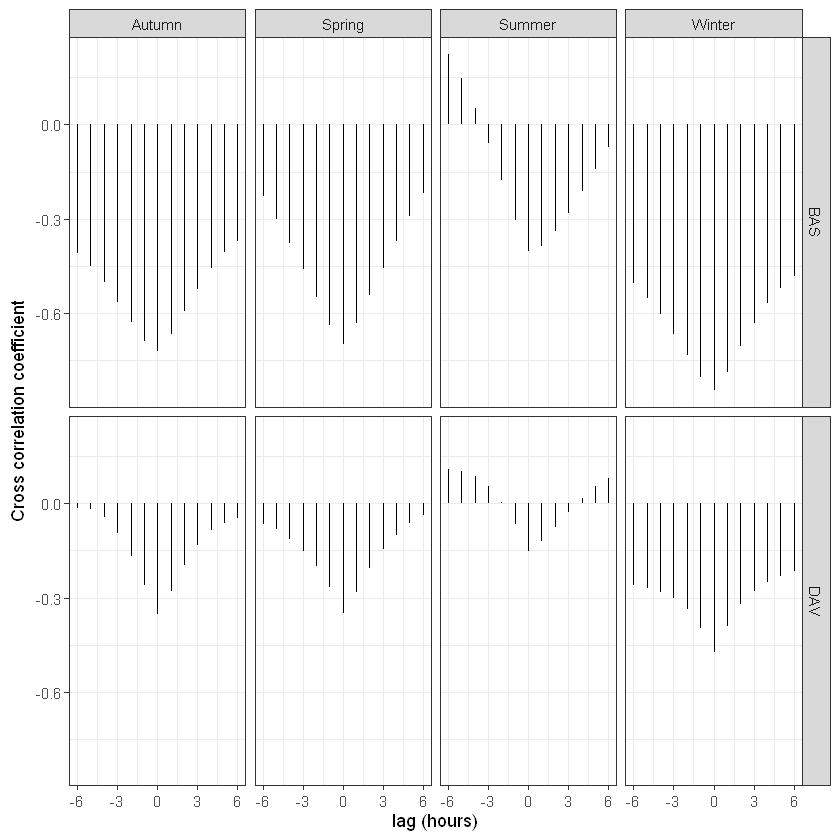

In [31]:
cross_corr_NO2_O3 <- ggplot(lagged_NO2_O3.values)+
  geom_segment(aes(x=lag,xend=lag,y=0,yend=value))+
  facet_grid(site~season)+
  xlab("lag (hours)")+
  ylab("Cross correlation coefficient")

cross_corr_NO2_O3
ggsave("outputs/cross_corr_NO2_O3.jpeg", plot = cross_corr_NO2_O3, width = 6, height = 5, dpi = 300)

### Adding NO values to df 

In [32]:
df$NO <- df$NOX - df$NO2

In [34]:
lagged_NO_O3.values <- df %>% 
  group_by(site, season) %>%
  do(LaggedCorrelation(select(., NO, O3), lag.max=6))

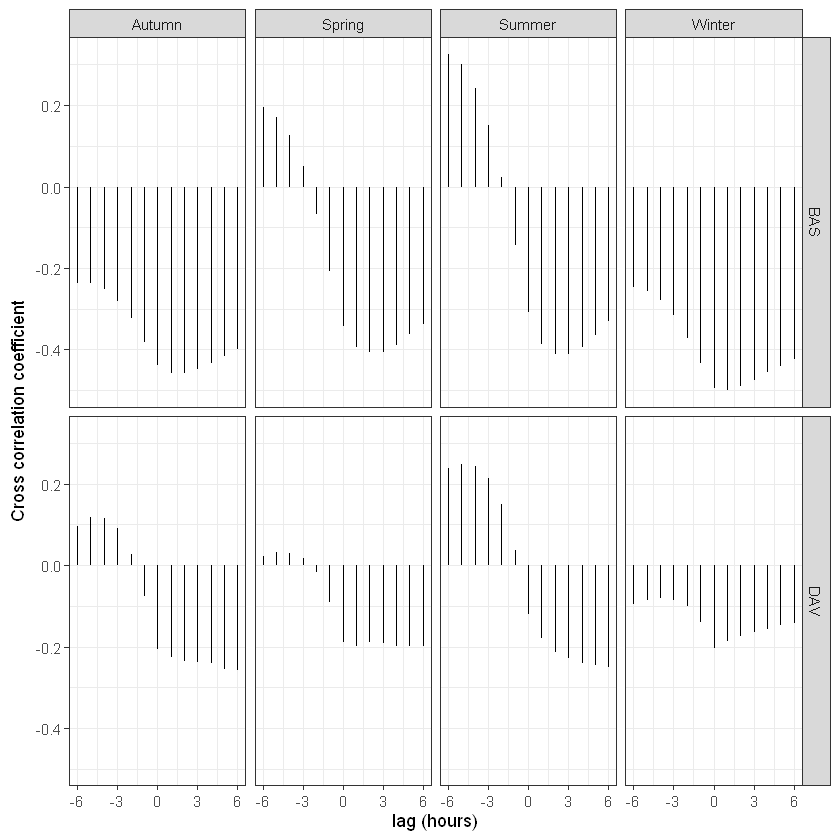

In [35]:
cross_corr_NO_O3 <- ggplot(lagged_NO_O3.values)+
  geom_segment(aes(x=lag,xend=lag,y=0,yend=value))+
  facet_grid(site~season)+
  xlab("lag (hours)")+
  ylab("Cross correlation coefficient")

cross_corr_NO_O3
ggsave("outputs/cross_corr_NO_O3.jpeg", plot = cross_corr_NO_O3, width = 6, height = 5, dpi = 300)

In [36]:
lagged_NOX_O3.values <- df %>% 
  group_by(site, season) %>%
  do(LaggedCorrelation(select(., NOX, O3), lag.max=6))

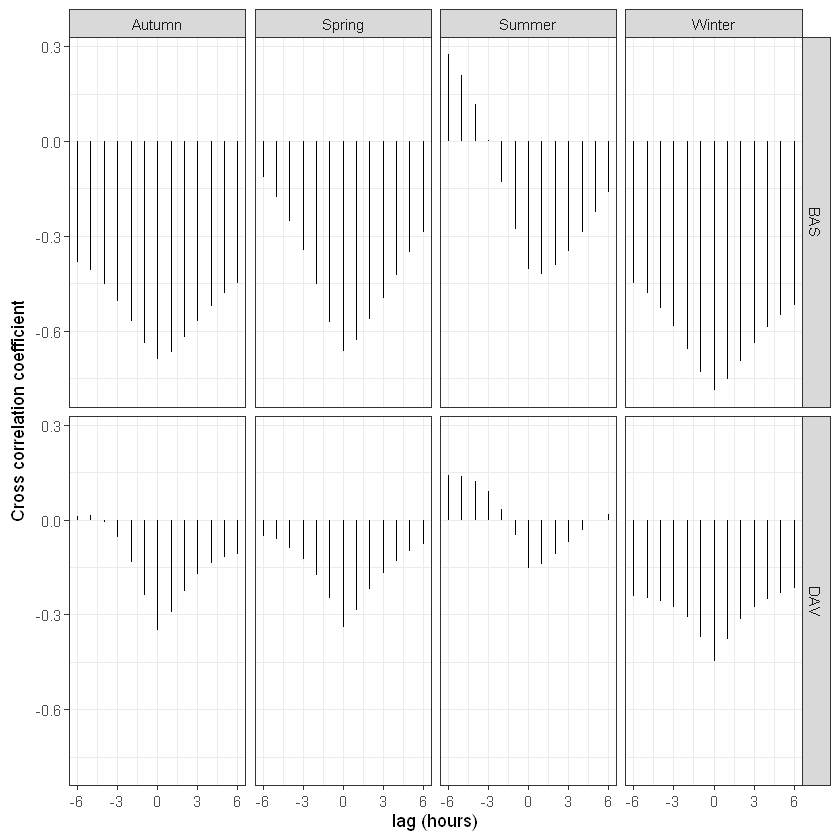

In [37]:
cross_corr_NOX_O3 <- ggplot(lagged_NOX_O3.values)+
  geom_segment(aes(x=lag,xend=lag,y=0,yend=value))+
  facet_grid(site~season)+
  xlab("lag (hours)")+
  ylab("Cross correlation coefficient")

cross_corr_NOX_O3
ggsave("outputs/cross_corr_NOX_O3.jpeg", plot = cross_corr_NOX_O3, width = 6, height = 5, dpi = 300)